# Imports

In [1]:
from helpers import get_rules, import_historic_prices, calculate_real_price, import_data

from gases import biogas
import numpy as np
import pandas as pd
import os
import time
import logging

# Parameters

In [2]:
from config import GAS_PARAMS
from config import GLOBAL_PARAMS
from config import CHP_PARAMS
from config import BOILER_PARAMS
from config import FLARE_PARAMS
from config import COOLER_PARAMS
from config import ELECTROLYZER_PARAMS
from config import METHANATION_PARAMS

# Runtime Data

In [3]:
df: pd.DataFrame = import_historic_prices(GLOBAL_PARAMS.DATAFILE_PATH)
df["Real Price / EURO/MWh"] = calculate_real_price(df["Price / EURO/MWh"].values)
df["Electricity Demand / kW"] = pd.read_csv(GLOBAL_PARAMS.ELECTRICITY_DEMAND_PATH)
df = import_data(df, GLOBAL_PARAMS.DATAFILE_PATH, "Gas Production / Nm^3/h")
df = import_data(df, GLOBAL_PARAMS.DATAFILE_PATH, "Fermenter Heat Demand / kW")

In [4]:
time_arr = df["Time / h"].values.astype(float)
time_diff = df["Time_diff / h"].values.astype(float)
raw_price = df["Price / EURO/MWh"].values.astype(float)
TOTAL_SIM_STEPS = len(df["Time / h"].values)

# Initialization

In [5]:
from infrastructures.gas_storage import GasStorage

biogas_storage = GasStorage(capacity=3000., initial_level=1000.)

In [6]:
from modules.chp import CHP

chps: list[CHP] = [None] * CHP_PARAMS.COUNT
for i, name in enumerate(CHP_PARAMS.NAMES):
    chps[i] = CHP(
        max_gas_power_uptake=CHP_PARAMS.MAX_POWER[name],
        efficiency_rules=get_rules(CHP_PARAMS.EFFICIENCY_RULES)[0][i],
        MTTR=CHP_PARAMS.FAILURE_RULES[name][1],
        MTTF=CHP_PARAMS.FAILURE_RULES[name][0],
        avg_time_diff=np.mean(
            df["Time_diff / h"].values.astype(float)).astype(float),  # type: ignore
        capex=CHP_PARAMS.CAPEX[name],
        fuel=biogas,
    )  # type: ignore

In [7]:
for chp in chps:
    print(f"""[CHP]: 
Max Gas Power Uptake: 
    {chp.max_gas_power_uptake} kW, 
Efficiency Rules: 
{chp.efficiency_rules}, 
MTTF: 
    {chp._MTTF}, 
MTTR: 
    {chp._MTTR}, 
Avg Time Diff: 
    {chp.avg_time_diff}, 
Stochastic Failure: 
    {chp._stochastic_failure}, 
Capex: 
    {chp.capex}
======================""")

[CHP]: 
Max Gas Power Uptake: 
    2086 kW, 
Efficiency Rules: 
[[0.    0.    0.   ]
 [0.54  0.373 0.494]
 [1.    0.408 0.448]], 
MTTF: 
    144.0, 
MTTR: 
    12.0, 
Avg Time Diff: 
    0.24994291585797465, 
Stochastic Failure: 
    False, 
Capex: 
    857346
[CHP]: 
Max Gas Power Uptake: 
    2086 kW, 
Efficiency Rules: 
[[0.    0.    0.   ]
 [0.54  0.373 0.494]
 [1.    0.408 0.448]], 
MTTF: 
    124.0, 
MTTR: 
    16.0, 
Avg Time Diff: 
    0.24994291585797465, 
Stochastic Failure: 
    False, 
Capex: 
    857346
[CHP]: 
Max Gas Power Uptake: 
    1302 kW, 
Efficiency Rules: 
[[0.    0.    0.   ]
 [0.55  0.373 0.494]
 [1.    0.408 0.448]], 
MTTF: 
    171.0, 
MTTR: 
    10.0, 
Avg Time Diff: 
    0.24994291585797465, 
Stochastic Failure: 
    False, 
Capex: 
    535122
[CHP]: 
Max Gas Power Uptake: 
    1302 kW, 
Efficiency Rules: 
[[0.    0.    0.   ]
 [0.55  0.373 0.494]
 [1.    0.408 0.448]], 
MTTF: 
    98.0, 
MTTR: 
    35.0, 
Avg Time Diff: 
    0.24994291585797465, 
Stochasti

In [8]:
from modules.boiler import Boiler

boilers: list[Boiler] = [None] * BOILER_PARAMS.COUNT
for i, name in enumerate(BOILER_PARAMS.NAMES):
    boilers[i] = Boiler(
        BOILER_PARAMS.MAX_POWER[name],
        get_rules(BOILER_PARAMS.EFFICIENCY_RULES)[0][i],
        get_rules(BOILER_PARAMS.STEPLESS_INTERVALS)[0][i],
        36.,
        100.,
        0.2,
        capex=BOILER_PARAMS.CAPEX[name],
        fuel=biogas)  # type: ignore

In [9]:
for boiler in boilers:
    print(f"""[Boiler]: 
Max output capacity: 
    {boiler.max_output_capacity}, 
Efficiency rules: 
{boiler.efficiency_rules}, 
Stepless bounds:
{boiler.stepless_bounds}, 
MTTR: 
    {boiler._MTTR}, 
Maintenance cost per hour: 
    {boiler._maintenance_cost_per_hour}, 
Capex: 
    {boiler.capex}
======================""")

[Boiler]: 
Max output capacity: 
    2448.0, 
Efficiency rules: 
[[0.  0. ]
 [0.3 0.9]
 [1.  0.9]], 
Stepless bounds:
[[0.3 1. ]], 
MTTR: 
    36.0, 
Maintenance cost per hour: 
    100.0, 
Capex: 
    166464
[Boiler]: 
Max output capacity: 
    2448.0, 
Efficiency rules: 
[[0.  0. ]
 [0.3 0.9]
 [1.  0.9]], 
Stepless bounds:
[[0.3 1. ]], 
MTTR: 
    36.0, 
Maintenance cost per hour: 
    100.0, 
Capex: 
    166464


In [10]:
from modules.electrolyzer import Electrolyzer
from gases import h2, h2o

electrolyzers: list[Electrolyzer] = [None] * ELECTROLYZER_PARAMS.COUNT
for i, name in enumerate(ELECTROLYZER_PARAMS.NAMES):
    electrolyzers[i] = Electrolyzer(
        # kW of electricity
        max_el_power_uptake=ELECTROLYZER_PARAMS.MAX_POWER[name],
        h2=h2, h2o=h2o,
        # see wwtp.py
        efficiency_rules=get_rules(ELECTROLYZER_PARAMS.EFFICIENCY_RULES)[0][i],
        # see wwtp.py
        stepless_intervals=get_rules(ELECTROLYZER_PARAMS.STEPLESS_INTERVALS)[0][i],
        # lambda in Poisson's Distribution in [(# of failures) / year]
        failure_rate=0.2,
        maintenance_cost_per_hour=10.0,  # €/h
        MTTF=10000.,  # mean time to failure in hours
        MTTR=120.,  # mean time to repair in hours
        capex=ELECTROLYZER_PARAMS.CAPEX[name],  # €
    )  # type: ignore

In [11]:
from modules.methanation import Methanation

methanations: list[Methanation] = [None] * METHANATION_PARAMS.COUNT
for i, name in enumerate(METHANATION_PARAMS.NAMES):
    methanations[i] = Methanation(
        max_biogas_power_uptake= METHANATION_PARAMS.MAX_POWER[name],
        efficiency_rules= get_rules(METHANATION_PARAMS.EFFICIENCY_RULES)[0][i],  # see wwtp.py
        stepless_intervals= get_rules(METHANATION_PARAMS.STEPLESS_INTERVALS)[0][i],  # see wwtp.py
        capex= METHANATION_PARAMS.CAPEX[name],  # 0.5 €/kW
    )  # type: ignore

In [12]:
from modules.fermenter import Fermenter

fermenter = Fermenter(
    0.5, 0.2, 1000, df["Gas Production / Nm^3/h"].values.astype(float), df["Fermenter Heat Demand / kW"].values.astype(float), 2000000)

In [13]:
from modules.flare import Flare
for i, name in enumerate(FLARE_PARAMS.NAMES):
    flare = Flare(
        capex=FLARE_PARAMS.CAPEX[name],
        max_gas_uptake=FLARE_PARAMS.MAX_GAS[name]
        )

In [14]:
from modules.cooler import Cooler
for i, name in enumerate(COOLER_PARAMS.NAMES):
    cooler = Cooler(
        capex=COOLER_PARAMS.CAPEX[name],
        max_heat_uptake=COOLER_PARAMS.MAX_HEAT[name]
        )

In [15]:
from infrastructures.heat_network import HeatNet

heat_net = HeatNet(cp=GAS_PARAMS.H2O["cp_l"], initial_temp=GLOBAL_PARAMS.HEAT_NET_INIT_TEMP)

In [16]:
from economics import Economics

economics_module = Economics()

In [17]:
from load_scheduler import LoadScheduler

operator = LoadScheduler(
    get_rules(CHP_PARAMS.STORAGE_RULES)[0],
    get_rules(CHP_PARAMS.MAINTENANCE_RULES)[0],
    chps,
    boilers,
    electrolyzers[0],
    methanations[0],
    biogas_storage,
    flare,
    fermenter,
    heat_net,
    cooler,
    economics_module
)

In [18]:
biogas_storage.level = 0  # Nm^3
biogas_storage.tendency = 1  # Nm^3/h
tic = time.time()
gross_cash_flow = 0
NPV = 0
net_cash_flow = 0
cumulative_purchased_electricity = np.zeros(TOTAL_SIM_STEPS)
consumption_costs = np.zeros(TOTAL_SIM_STEPS)
cumulative_consumption_cost = np.zeros(TOTAL_SIM_STEPS)

In [19]:
chp_stat_records = np.empty((TOTAL_SIM_STEPS, CHP_PARAMS.COUNT, chps[0].report_status().shape[0]))
boiler_stat_records = np.empty((TOTAL_SIM_STEPS, BOILER_PARAMS.COUNT, boilers[0].report_status().shape[0]))
flare_stat_records = np.empty((TOTAL_SIM_STEPS, flare.report_status().shape[0]))
cooler_stat_records = np.empty((TOTAL_SIM_STEPS, cooler.report_status().shape[0]))
biogas_storage_records = np.empty((TOTAL_SIM_STEPS, 2)) # level, tendency
heatnet_records = np.empty((TOTAL_SIM_STEPS))

economic_records = np.empty((TOTAL_SIM_STEPS, 3)) # gross_cash_flow, net_cash_flow, NPV

In [20]:
peak_load = df["Electricity Demand / kW"].max()

In [21]:
net_cash_flows = np.zeros(TOTAL_SIM_STEPS)

# Simulation Loop

In [22]:
for k in range(1, TOTAL_SIM_STEPS - 1):
	net_inflow = fermenter.gas_production[k]
	biogas_storage.store(net_inflow, time_diff[k])

	operator.schedule_production(time_arr[k], raw_price[k], GLOBAL_PARAMS.MASS_FLOW_HEAT_NET, np.array((70,80)), chps, boilers, electrolyzers, methanations, biogas_storage, flare, fermenter, heat_net, cooler)

	[chp.step(time_diff[k]) for chp in chps]
	[boiler.step(time_diff[k]) for boiler in boilers]
	flare.step(time_diff[k])
	cooler.step(time_diff[k])
	# electrolyzers[0].step(time_diff[k])

	# TODO: Jonas, please insert consume and produce method of methanation to load scheduler
	h2_el, gas, el = methanations[0]._consume(np.random.normal())
	sng, h2o, thermal = methanations[0]._produce(np.random.normal())

	heat_net.new_temperature(
		np.sum([boiler.Products[0] * time_diff[k] for boiler in boilers])
	  + np.sum([chp.Products[1] * time_diff[k] for chp in chps]) 
	  + thermal * time_diff[k]
	  - fermenter.heat_demand[k] * time_diff[k]
	  - cooler.Consumption[0] * time_diff[k], 
		GLOBAL_PARAMS.MASS_FLOW_HEAT_NET
	)
	
	net_outflow = gas + np.sum([chp.Consumption[0] for chp in chps]) + np.sum([boiler.Consumption[0] for boiler in boilers]) + flare.Consumption[0]

	net_electricity = df["Electricity Demand / kW"][k] - np.sum([chp.Products[0] for chp in chps]) # + electrolyzers[0].Consumption[0]
	net_oxygen = GLOBAL_PARAMS.O2_CONSUMPTION / 4 # per 15 min

	biogas_storage.fetch(net_outflow, time_diff[k])
	biogas_storage_records[k, :] = np.array([biogas_storage.level, biogas_storage.tendency])
	biogas_storage.step()
	
	economic_records[k] = operator.get_economic_stats(net_electricity / 1000 * 0.25, net_oxygen, k)

	chp_stat_records[k, :, :] = np.array([chp.report_status() for chp in chps])
	flare_stat_records[k, :] = flare.report_status()
	boiler_stat_records[k, :, :] = np.array([boiler.report_status() for boiler in boilers])
	cooler_stat_records[k, :] = cooler.report_status()
	heatnet_records[k] = heat_net.temperature
	

	if time_arr[k] % (365 * 24) == 0 :
		NPV += net_cash_flow / (1 + GLOBAL_PARAMS.BANK_INTEREST_RATE) ** (time_arr[k] / (365 * 24)) # 5% discount rate
		

	# every 1000 timesteps, print the current timestep as info log level
	if k % 10000 == 0:
		logging.info("timestep: " + str(k) + " of " + str(len(time_arr)))

	# For debugging, print a timestep near the problem to stop sim there
	if time_arr[k] == 7100 * 3:
		logging.debug("timestep: " + str(k) + " of " + str(len(time_arr)))

# Stop the stopwatch
toc = time.time()

In [23]:
GLOBAL_PARAMS.O2_CONSUMPTION / 4 * TOTAL_SIM_STEPS

187124.6483

In [24]:
df["Electricity Demand / kW"].sum() * 0.25

24473260.591453005

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

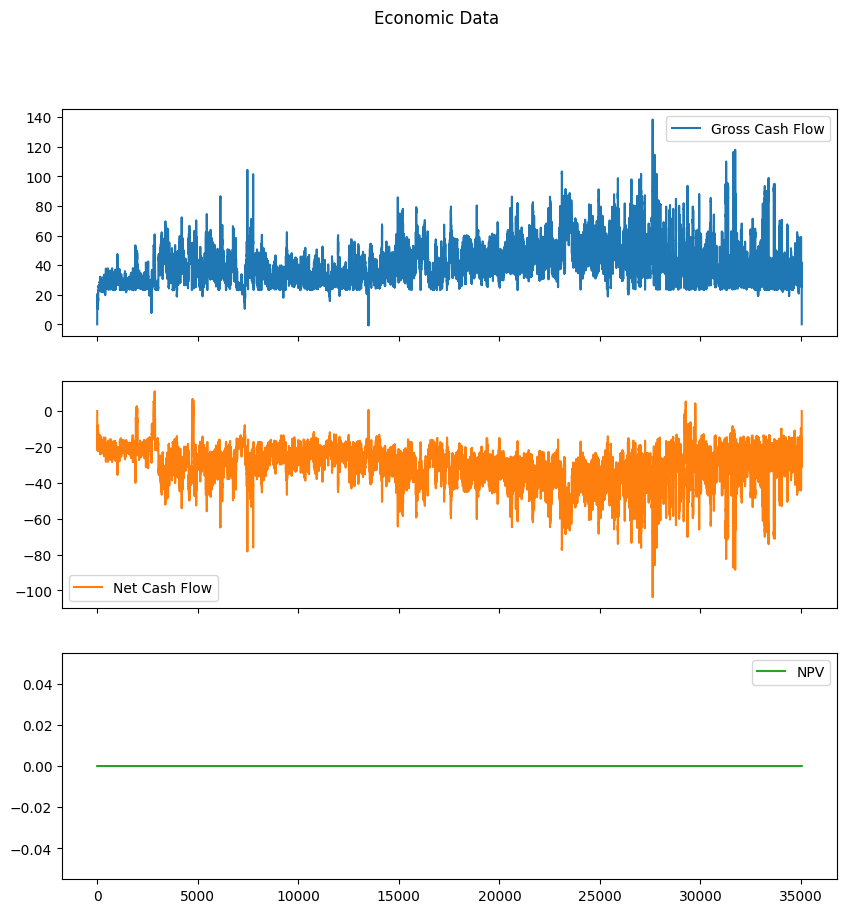

In [26]:
economic_data = pd.DataFrame(economic_records, columns=['Gross Cash Flow', 'Net Cash Flow', 'NPV'])
_ = economic_data.plot(subplots=True, figsize=(10,10), title=f'Economic Data')

<AxesSubplot: >

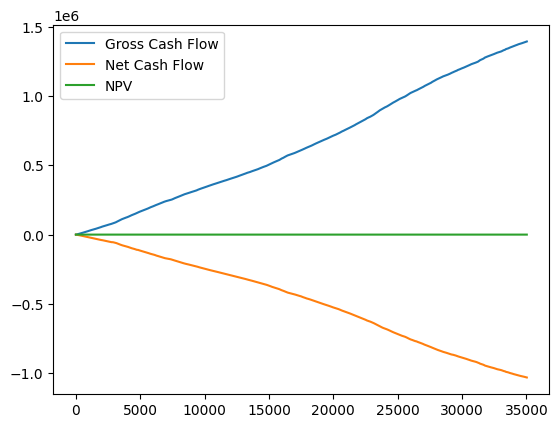

In [27]:
economic_data.cumsum().plot()

In [28]:
sns.lineplot(fermenter.gas_production)

<AxesSubplot: >

<AxesSubplot: >

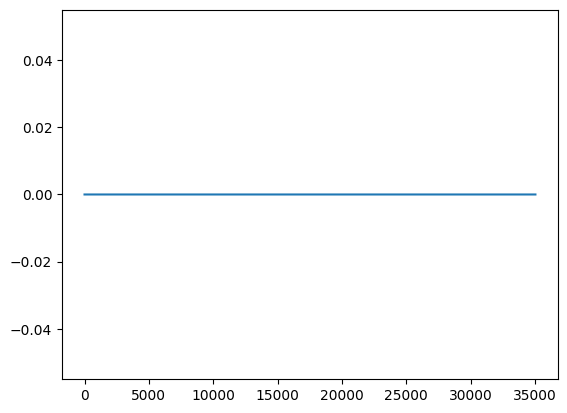

In [29]:
sns.lineplot(consumption_costs)

<AxesSubplot: >

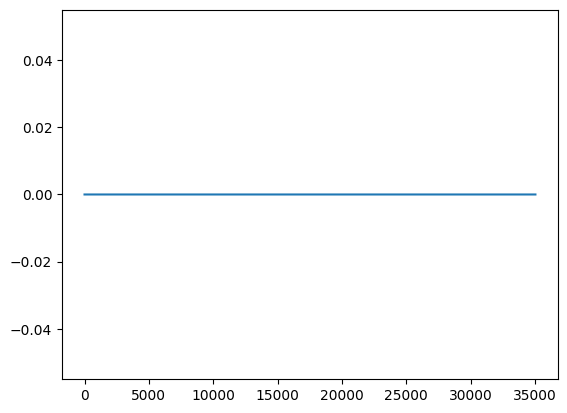

In [30]:
sns.lineplot(cumulative_consumption_cost)

<AxesSubplot: >

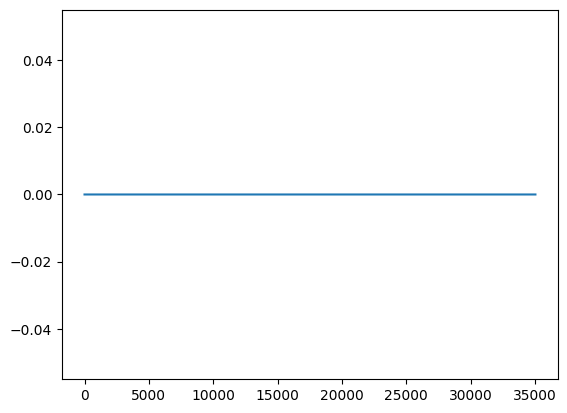

In [31]:
sns.lineplot(net_cash_flows[:-1])

<AxesSubplot: >

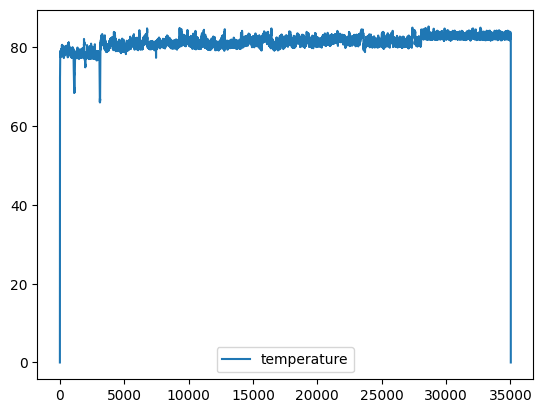

In [32]:
sns.lineplot(heatnet_records, label="temperature")

In [33]:
pd.DataFrame(chp_stat_records[:,:,2]).sum().sum() / 4

12457418.015489932

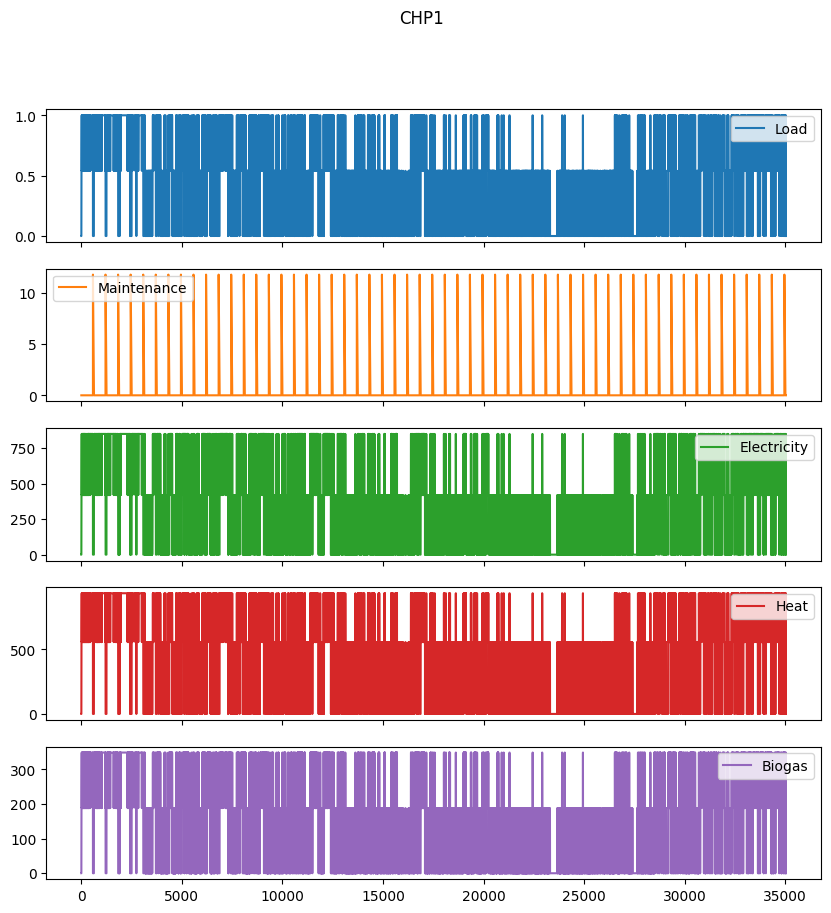

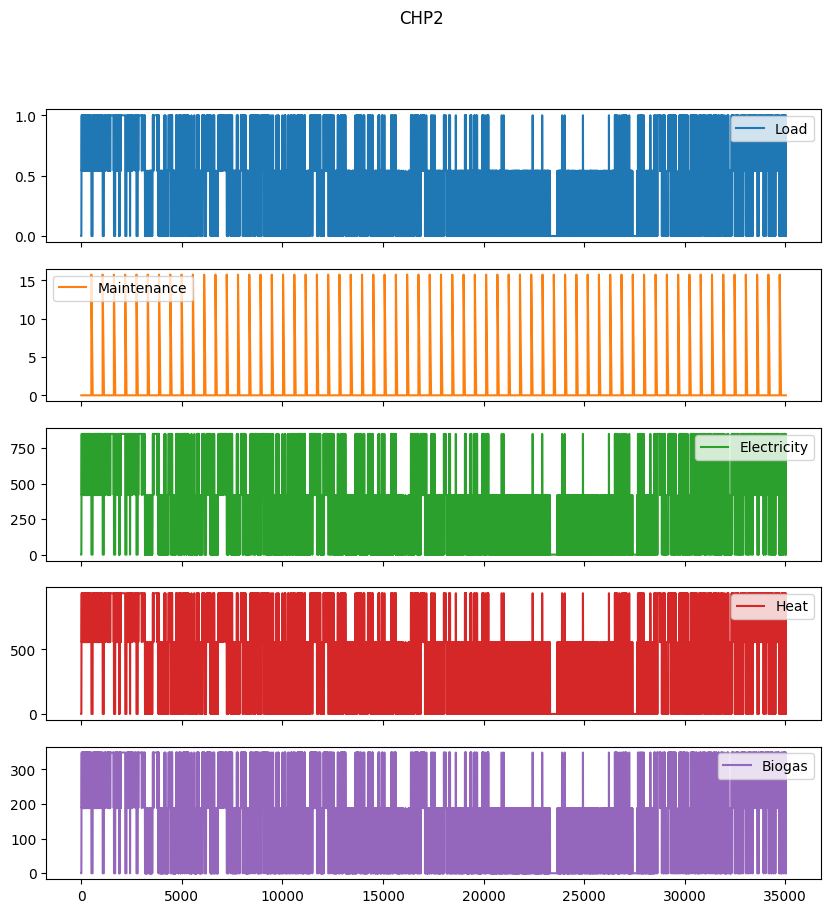

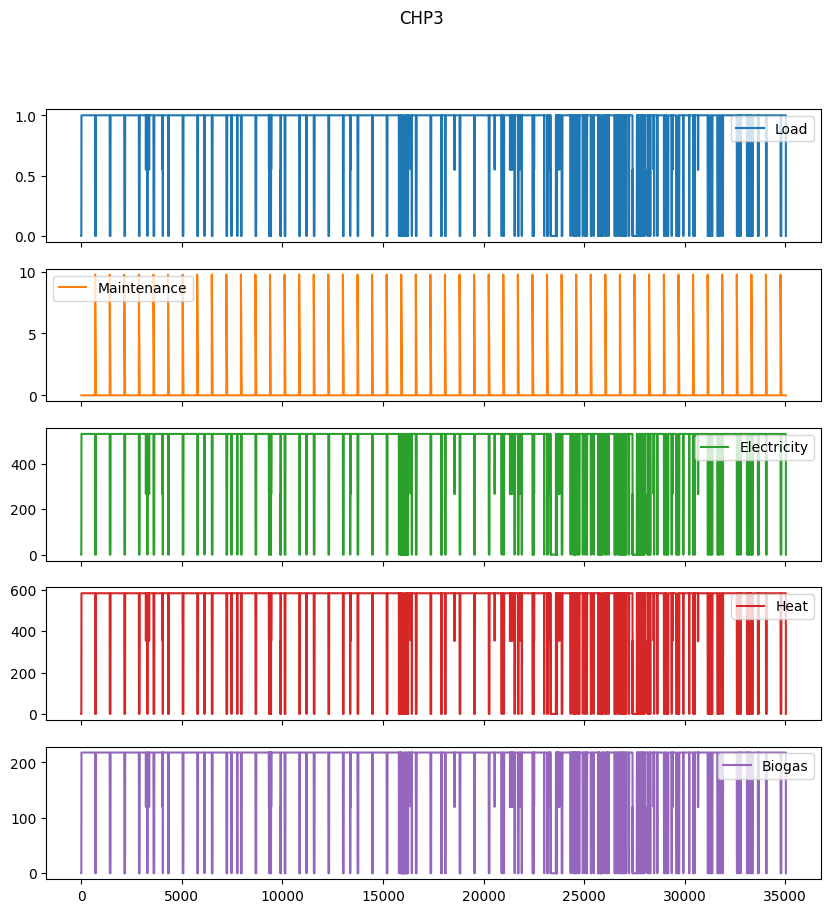

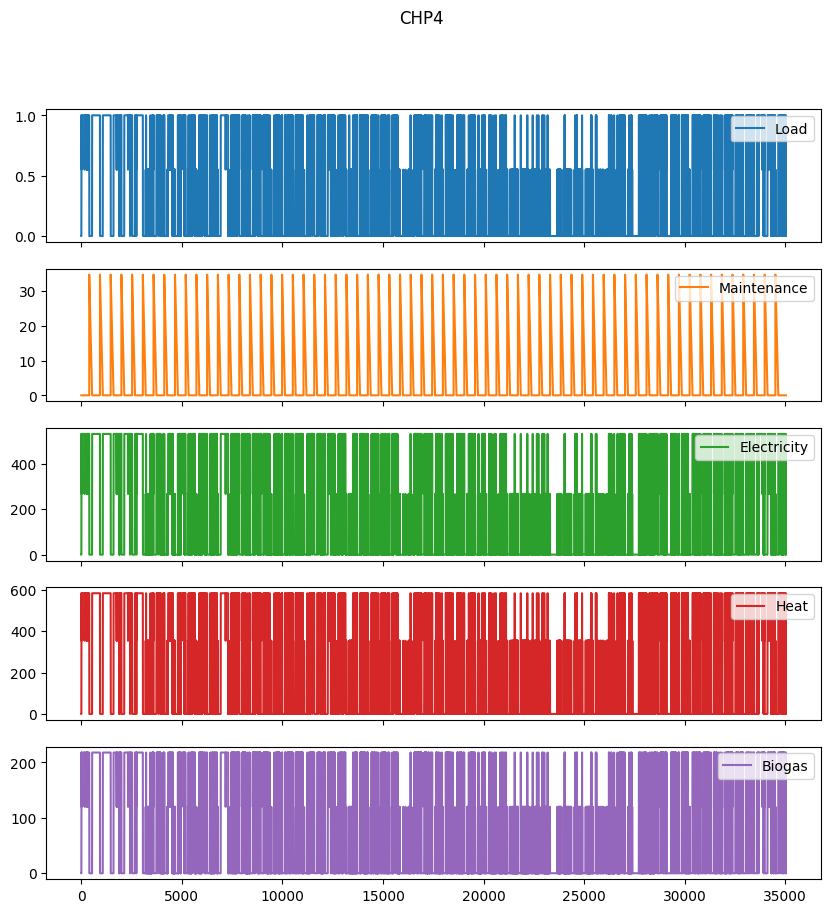

In [34]:
for i in range(CHP_PARAMS.COUNT):
    chp_data = pd.DataFrame(chp_stat_records[:,i,:], columns=['Load', 'Maintenance', 'Electricity', 'Heat', 'Biogas'])
    _ = chp_data.plot(subplots=True, figsize=(10,10), title=f'CHP{i+1}')

In [35]:
for i in range(BOILER_PARAMS.COUNT):
    boiler_data = pd.DataFrame(boiler_stat_records[:,i,:], columns=['Load', 'Maintenance', 'Heat', 'Biogas'])
    _ = boiler_data.plot(subplots=True, figsize=(10,10), title=f'Boiler{i+1}')

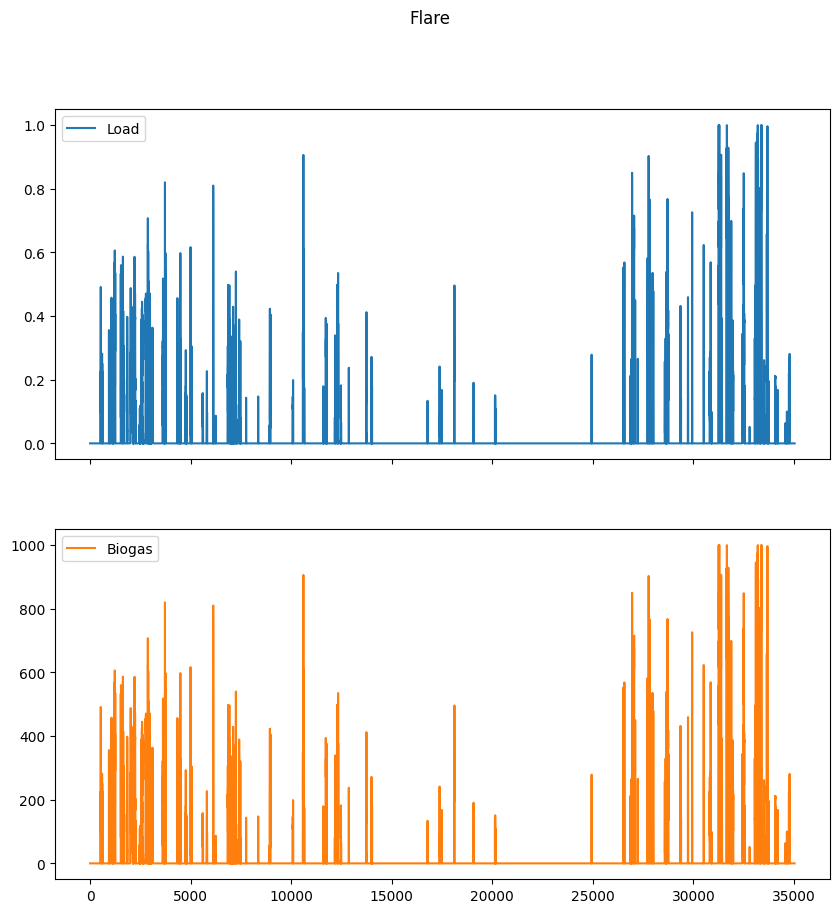

In [36]:
flare_data = pd.DataFrame(flare_stat_records[:,(0,3)], columns=['Load', 'Biogas'])
_ = flare_data.plot(subplots=True, figsize=(10,10), title=f'Flare')

In [37]:
storage_data = pd.DataFrame(biogas_storage_records, columns=['Level', 'Tendency'])
_ = storage_data.plot(subplots=True, figsize=(10,10), title=f'Biogas Storage')